<a href="https://colab.research.google.com/github/livinotami/livinotami.github.io/blob/master/BindsNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BindsNETによる神経シミュレーション
BindsNETは単なるシミュレーションとしての用途だけではなく、SNN(Spiking Neural Network)として機械学習を行うことが可能です。

順番に Shift + Enter を押していくだけで、シミュレーションが可能です。

参考文献

１．公式ドキュメント　https://bindsnet-docs.readthedocs.io/

２．BindsNETでSNNを試してみる　https://qiita.com/takeajioka/items/98225ce8c2ce953c5fd5

３．Spiking Neural Networksライブラリ ー BindsNETを触ってみる【Python】 https://hirlab.net/nblog/category/programming/art_599/

## BindsNETのインストール

In [4]:
!pip install bindsnet


これで、GoogleColab上でBindsNETが使えるようになりました。(制限時間12時間)

次からは、デモを行います。

In [5]:
!pip install bindsnet torch matplotlib numpy

## デモ１　2層のネットワークのシミュレーション
'A'と'B'の2つの層からなるネットワークでシミュレーションを行います。

In [6]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages

In [7]:
# シミュレーション時間(ms)
time = 500

# ネットワークの作成
network = Network()
source_layer = Input(n=100)
target_layer = LIFNodes(n=10)
network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)


In [8]:
# AからBへの結合を作成
forward_connection = Connection(
    source=source_layer,
    target=target_layer,
    w=0.05 + 0.1 * torch.randn(source_layer.n, target_layer.n),  # Normal(0.05, 0.01) weights.
)

network.add_connection(
    connection=forward_connection, source="A", target="B"
)

In [9]:
# BからBへのリカレントな結合を作成
recurrent_connection = Connection(
    source=target_layer,
    target=target_layer,
    w=0.025 * (torch.eye(target_layer.n) - 1), # Small, inhibitory "competitive" weights.
)

network.add_connection(
    connection=recurrent_connection, source="B", target="B"
)

In [10]:
# ネットワークの概要を表示
network

Network(
  (A): Input()
  (B): LIFNodes()
  (A_to_B): Connection(
    (source): Input()
    (target): LIFNodes()
  )
  (B_to_B): Connection(
    (source): LIFNodes()
    (target): LIFNodes()
  )
)

In [11]:
# モニタ変数の設定
source_monitor = Monitor(
    obj=source_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=target_monitor, name="B")


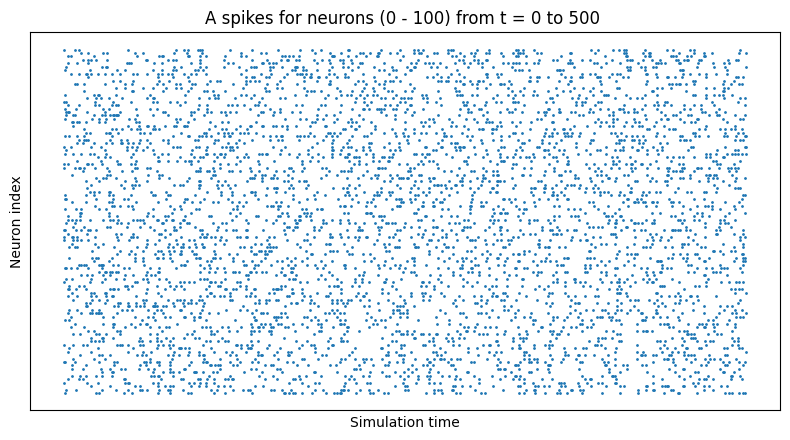

In [12]:
# A層へ入力するスパイクを設定（p = 0.1のベルヌーイ分布で入力スパイクを作成）
input_data = torch.bernoulli(0.1 * torch.ones(time, source_layer.n)).byte()
inputs = {"A": input_data}
plot_spikes(inputs)
plt.show()

In [13]:
# シミュレーションの実行
network.run(inputs=inputs, time=time)

In [14]:
# 結果データのまとめ
spikes = {
    "A": source_monitor.get("s"), "B": target_monitor.get("s")
}
voltages = {"B": target_monitor.get("v")}

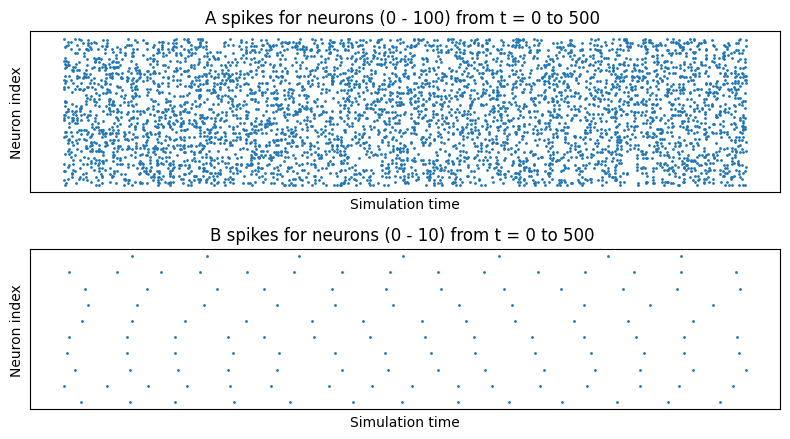

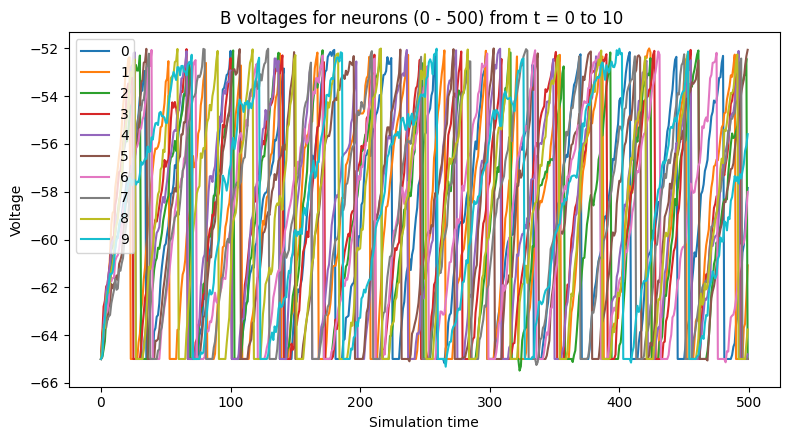

In [15]:
# プロット
plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.legend(range(10))
plt.show()

BindsNETでは活動電位までは再現されません。(LIFニューロンモデルのため)

最後の図では、本当はneuronが0-9の10個でt= 0 to 500であるため表示のミスがありました。(BindsNETのライブラリのバグによるもの)

また、100以上の細胞ではラスタープロットが表示されないバグもありました。

## デモ２　SNNでMNISTを学習してみる
MNISTは手書きの数字認識を行うためのデータセットです。

https://github.com/HiroshiARAKI/snnlibpy で公開されているWrapperを使うと簡単に行うことが出来ます。

In [23]:
!git clone https://github.com/HiroshiARAKI/snnlibpy.git

fatal: destination path 'snnlibpy' already exists and is not an empty directory.


In [32]:
!pip install timm==0.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.11
    Uninstalling timm-1.0.11:
      Successfully uninstalled timm-1.0.11


In [39]:
from snnlibpy.wbn.snnlib import Spiking

In [40]:
# SNNsを作成
snn = Spiking(input_l=784, obs_time=100, dt=1.0)

snn.add_layer(n=100,
              node=snn.DIEHL_COOK,          # or snn.DIEHL_COOK
              w=snn.W_SIMPLE_RAND,   # initialize weights
              rule=snn.SIMPLE_STDP,  # learning rule
              nu=(1e-4, 1e-2),       # learning rate
              )

snn.add_inhibit_layer(inh_w=-128)

You Called Spiking Neural Networks Library "WBN"!!
=> WrappedBindsNET (This Library) :version. 0.2.6
-- Added fc-0 with the Learning rule, Simple_STDP
-- Added inh[fc-0] as an inhibitory layer


In [41]:
# ネットワークの概要を表示
snn.print_model()

Show your network information below.
Layers:
 in(784)
    |
 fc-0(100)
    |
 inh[fc-0](100)
    |
  [END]
Simulation Time: 100, dt: 1.0


In [42]:
# MNISTをロード
snn.load_MNIST()

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]


Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/train-images-idx3-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/train-labels-idx1-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/t10k-images-idx3-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.97MB/s]

Extracting /content/data/mnist/TorchvisionDatasetWrapper/raw/t10k-labels-idx1-ubyte.gz to /content/data/mnist/TorchvisionDatasetWrapper/raw



In [43]:
# GPUの使用（しなくても可）
snn.to_gpu()

GPU computing is available.


True

Plot weight map 100/100
Plotting... Done!


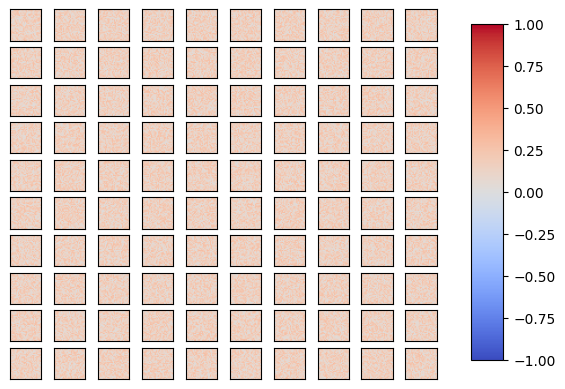

In [44]:
# トレーニング前のWeight Mapsを生成
snn.plot(plt_type='wmps', prefix='0', save=False, f_shape=(10, 10))

In [45]:
# シミュレーション(トレーニング)を実行（30分ほどかかる）
snn.run(tr_size=10000, unsupervised=False)

Progress: 10000 / 10000 (2964.1873 seconds): 10000it [49:24,  3.37it/s]

Progress: 10000 / 10000 (2964.4498 seconds)
===< Have finished running the network >===



Plot weight map 100/100
Plotting... Done!


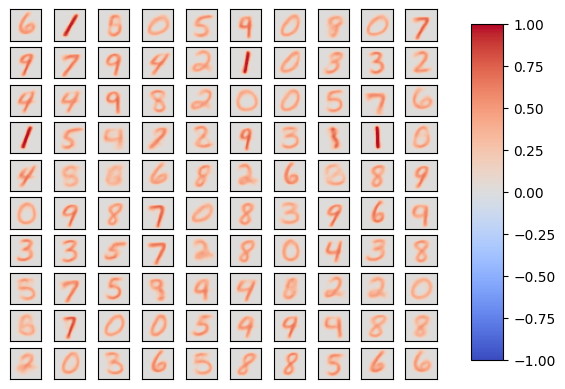

In [46]:
# トレーニング後のWeight Mapsを生成
snn.plot(plt_type='wmps', save=False, prefix='result', f_shape=(10, 10))

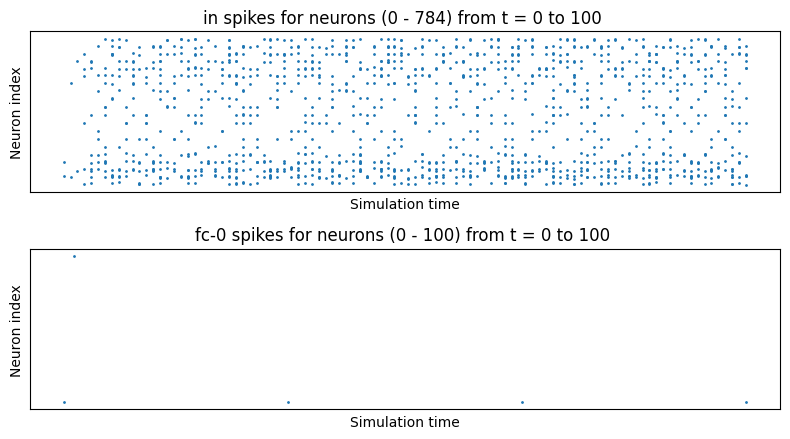

In [47]:
# 画像入力に対するスパイクをプロット
snn.plot(plt_type='sp', save=False,range=1)

シミュレーションによって、Weight Mapに数字が写し出されるようになりました。

また画像の入力に対して、一定の細胞が反応しているような結果になりました。

ただし、本当はもっと時間をかけて学習させる必要があります。